# DEA Intertidal Elevation

This notebook demonstrates how to run and customise a DEA Intertidal Elevation analysis.

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r dev-requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import os

import datacube
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from dea_tools.dask import create_local_dask_cluster
from eo_tides.eo import pixel_tides
from odc.geo.geom import Geometry

from intertidal.elevation import (
    clean_edge_pixels,
    ds_to_flat,
    flat_to_ds,
    pixel_dem,
    pixel_dem_debug,
    pixel_rolling_median,
    pixel_uncertainty,
)
from intertidal.extents import load_connectivity_mask
from intertidal.io import (
    load_data,
    load_topobathy_mask,
    prepare_for_export,
)

## Setup


### Set analysis parameters

In [3]:
# Intertidal Elevation variables
start_date = "2018"  # Start date for analysis
end_date = "2020"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
min_freq = 0.01  # Minimum wetness freq required for pixel to be included in analysis
max_freq = 0.99  # Maximum wetness freq required for pixel to be included in analysis
min_correlation = 0.15  # Minimum correlation between water index and tide height
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "EOT20"  # Tide model to use in analysis
tide_model_dir = "/var/share/tide_models/"

#### Set study area

##### Option 1: load study area from 32 km tile GridSpec

In [4]:
# # Set study area (e.g. tile ID in form "x094y145")
# study_area = "x174y083"
# geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

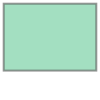

In [5]:
# Set study area to load from file
study_area = "gulfcarpentaria1"

# Read file, select study area and convert to geom
studyarea_gdf = gpd.read_file("data/raw/intertidal_development_polygons.geojson").set_index("id")
geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
geom

##### Option 3: load study area using interactive map

In [6]:
# # Set study area name for outputs
# study_area = "testing"

# # Plot interactive map to select area
# basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
# geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
# geom

## Load data

<div class="alert alert-info">

**Note:** If you are wanting to run an analysis for a location outside of Australia or you do not have access to a pre-configured Datacube, consider loading data using [SpatioTemporal Asset Catalogue (STAC) metadata](../notebooks/Intertidal_elevation_stac.ipynb) instead.

</div>

In [7]:
%%time

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds, _, _ = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

print(satellite_ds)

# Load data
satellite_ds.load()

<Client: 'tcp://127.0.0.1:36757' processes=1 threads=62, memory=456.00 GiB>

<xarray.Dataset> Size: 520MB
Dimensions:      (time: 490, y: 446, x: 595)
Coordinates:
  * time         (time) datetime64[ns] 4kB 2018-01-01T01:07:20.459000 ... 202...
  * y            (y) float64 4kB -1.639e+06 -1.639e+06 ... -1.643e+06 -1.643e+06
  * x            (x) float64 5kB 4.475e+05 4.476e+05 ... 4.535e+05 4.535e+05
    spatial_ref  int32 4B 3577
Data variables:
    ndwi         (time, y, x) float32 520MB dask.array<chunksize=(1, 446, 595), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref
CPU times: user 26 s, sys: 1.07 s, total: 27 s
Wall time: 1min 57s


<xarray.Dataset> Size: 520MB
Dimensions:      (time: 490, y: 446, x: 595)
Coordinates:
  * time         (time) datetime64[ns] 4kB 2018-01-01T01:07:20.459000 ... 202...
  * y            (y) float64 4kB -1.639e+06 -1.639e+06 ... -1.643e+06 -1.643e+06
  * x            (x) float64 5kB 4.475e+05 4.476e+05 ... 4.535e+05 4.535e+05
    spatial_ref  int32 4B 3577
Data variables:
    ndwi         (time, y, x) float32 520MB 0.3841 0.3789 ... -0.1996 -0.1703
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Pixel-based tides

Model tides into every pixel in the three-dimensional (`x, y, time`) satellite dataset.

<!-- ensemble_models=[
    "EOT20",
    "FES2012",
    "FES2014_extrapolated",
    "FES2022_extrapolated",
    # "HAMTIDE11",
    "GOT4.10",
    "GOT5.6_extrapolated",
    "TPXO10-atlas-v2-nc",
    "TPXO8-atlas-nc",
    "TPXO9-atlas-v5-nc",
],
ensemble_func={"ensemble-mean-weightedtop3": lambda x: (4 - x["rank"]).clip(0, 3)}, -->

In [8]:
# If `model` is "ensemble" this generate optimised
# tide modelling by combining the best local tide models.
tide_m = pixel_tides(
    data=satellite_ds,
    model=tide_model,
    directory=tide_model_dir,
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with EOT20
Reprojecting tides into original resolution


In [9]:
# Set tide array pixels to nodata if the satellite data array pixels contain
# nodata. This ensures that our population of tide heights reflects the
# clear, cloud-free satellite observations we have available.
satellite_ds["tide_m"] = tide_m.where(~satellite_ds.to_array().isel(variable=0).isnull().drop("variable"))

## Pixel-based DEM creation

### Load optional masks
Load a topo-bathymetric DEM into the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

We also generate a coastal mask, based on the connectivity of each pixel to the ocean.
Coastal pixels are identified by calculating "least-cost" distances from ocean weighted by elevation, where low, flat areas of terrain are assigned lower weights than high, steep pixels.
This produces a coastal mask that extends further inland in low-lying coastal areas.

<div class="alert alert-info">

**Note:** These steps are used to produce cleaner outputs for the Australian implementation of DEA Intertidal. 
They are optional and can be skipped.

</div>

In [10]:
# Load data from GA's AusBathyTopo 250m 2023 Grid
topobathy_mask = load_topobathy_mask(
    dc=dc,
    geobox=satellite_ds.odc.geobox,
    product="ga_ausbathytopo250m_2023",
    resampling="bilinear",
    min_threshold=-15,
    mask_filters=[("dilation", 25)],
)

In [11]:
# Generate coastal connectivity mask to exclude non-tidal areas
coastal_mask, _ = load_connectivity_mask(
    dc=dc,
    geobox=satellite_ds.odc.geobox,
    product="ga_srtm_dem1sv1_0",
    elevation_band="dem_h",
    resampling="bilinear",
    max_threshold=20,
    add_mangroves=True,
    correct_hat=True,
)

Loading SRTM data at native 30 m resolution
Adding GMW mangroves to starting points
Applying HAT correction
Running cost distance calculation
Reprojecting back to original GeoBox resolution


### Flatten array from 3D to 2D and drop pixels with no correlation with tide
Flatten array to only pixels with positive correlations between water observations and tide height. This greatly improves processing time by ensuring only a narrow strip of pixels along the coastline are analysed, rather than the entire x * y array:


![](../data/figures/tide_array_flattening.JPG)

<div class="alert alert-info">

**Note:** For Australia, we pass in a custom `valid_mask` to constrain the analysis to probable coastal pixels. 
This is optional, and can be skipped (at the expense of slightly less clean outputs and longer runtimes) by commenting out `valid_mask=...`.

</div>

In [12]:
%%time
flat_ds, freq, corr, clear = ds_to_flat(
    satellite_ds,
    min_freq=min_freq,
    max_freq=max_freq,
    min_correlation=min_correlation,
    valid_mask=topobathy_mask & coastal_mask,
)

Reducing analysed pixels from 265370 to 82808 (31.20%)
CPU times: user 3.7 s, sys: 1.81 s, total: 5.51 s
Wall time: 5.28 s


### Pixel-wise rolling median
This function performs a rolling median calculation along the tide heights of our satellite images. 
It breaks our tide range into `windows_n` individual rolling windows, each of which covers `windows_prop_tide` of the full tidal range. 
For each window, the function returns the median of all tide heights and NDWI index values within the window, and returns an array with a new "interval" dimension that summarises these values from low to high tide.

More windows (e.g. `windows_n=100`) produces detailed elevation maps that can capture small differences in intertidal morphology - at the expense of slower run times.
Fewer windows (e.g. `windows_n=50`) will run faster, but produce less smooth, less detailed elevation maps.

In [13]:
%%time
interval_ds = pixel_rolling_median(
    flat_ds,
    windows_n=50,
    window_prop_tide=0.15,
    max_workers=None,
    min_count=5,
)

  0%|          | 0/55 [00:00<?, ?it/s]

CPU times: user 12.5 s, sys: 25.8 s, total: 38.3 s
Wall time: 53.9 s


### Model intertidal elevation and uncertainty

Optionally test our workflow by plotting an example elevation extraction for a single pixel:

Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 10


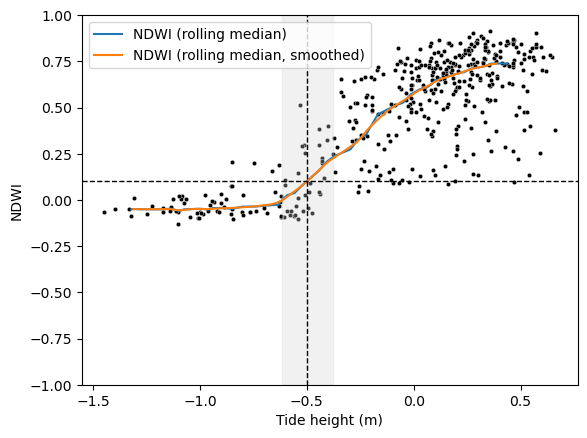

In [14]:
x, y = 450439, -1641017
pixel_df, pixel_median_df, pixel_median_smoothed_df = pixel_dem_debug(
    x,
    y,
    flat_ds,
    interval_ds,
    interp_intervals=200,
    smooth_radius=10,
    min_periods=5,
    # plot_style="season",
)

Now model our full elevation raster:

In [15]:
# Model elevation
flat_dem = pixel_dem(
    interval_ds,
    ndwi_thresh=ndwi_thresh,
    interp_intervals=200,
    smooth_radius=20,
    min_periods=5,
)

Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


In [16]:
# Model uncertainty
low, high, uncertainty, misclassified = pixel_uncertainty(flat_ds, flat_dem, ndwi_thresh, method="mad")

# Add arrays to dataset
flat_dem[["elevation_low", "elevation_high", "elevation_uncertainty"]] = (
    low,
    high,
    uncertainty,
)

## Unstack outputs and export

In [17]:
# Combine QA layers with elevation layers
flat_combined = xr.combine_by_coords(
    [
        flat_dem,  # DEM data
        freq,  # Frequency
        corr,  # Correlation
        clear,  # Clear count
    ],
)

# Unstack elevation and uncertainty layers back into their original
# spatial dimensions
ds = flat_to_ds(flat_combined, satellite_ds)

# Clean upper edge of intertidal zone in elevation layers
# (likely to be inaccurate edge pixels)
elevation_bands = [d for d in ds.data_vars if "elevation" in d]
ds[elevation_bands] = clean_edge_pixels(ds[elevation_bands])

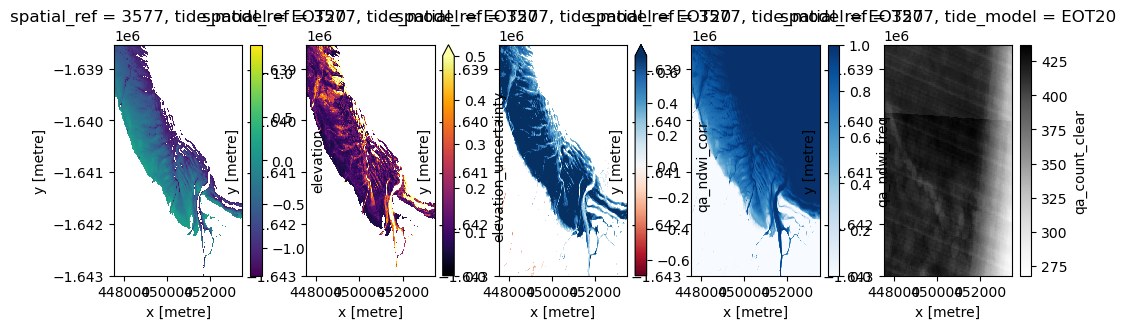

In [18]:
fix, axes = plt.subplots(1, 5, figsize=(12, 3))
ds.elevation.plot.imshow(cmap="viridis", ax=axes[0])
ds.elevation_uncertainty.plot.imshow(cmap="inferno", vmin=0, vmax=0.5, ax=axes[1])
ds.qa_ndwi_corr.plot.imshow(cmap="RdBu", vmin=-0.7, vmax=0.7, ax=axes[2])
ds.qa_ndwi_freq.plot.imshow(cmap="Blues", vmin=0, vmax=1, ax=axes[3])
ds.qa_count_clear.plot.imshow(cmap="Greys", ax=axes[4])

In [19]:
ds.elevation.odc.explore(robust=True)

### Export to GeoTIFF files

In [20]:
# Create output folder if it doesn't exist
output_dir = f"data/interim/{study_area}/{start_date}-{end_date}"
os.makedirs(output_dir, exist_ok=True)

# Prepare data for export
ds["qa_ndwi_freq"] *= 100  # Convert frequency to %

# Prepare for export by correctly setting nodata and dtypes, then
# export to file
ds_prepared = prepare_for_export(ds, output_location=output_dir)

## Close Dask client

In [21]:
client.close()